In [1]:
from encoder_arch import TransformerEncoder
import numpy as np
import tensorflow as tf
import subprocess
import logging

2024-12-23 14:04:30.064340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# config = tf.config.threading.set_inter_op_parallelism_threads(1)
# config = tf.compat.v1.ConfigProto()
# config.intra_op_parallelism_threads = 1
# config.inter_op_parallelism_threads = 1
# config.use_per_session_threads=False
# serialized_config = config.SerializeToString()
# byte_array = list(serialized_config)
# print("uint8_t config[] = {" + ", ".join([hex(b) for b in byte_array]) + "};")

uint8_t config[] = {0x10, 0x1, 0x28, 0x1};


In [2]:
def count_params(model):
    return np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

def run_inference(binary_path, model_path, seq_len, num_runs=100):
    result = subprocess.run([binary_path, model_path, str(seq_len)], capture_output=True, text=True)
    stderr = result.stderr.strip()
    
    logging.error("STDERR\n" + stderr)
    output = result.stdout.strip().split('\n')
    logging.error(output)
    avg_time = float(output[-2].split(':')[1].strip().split()[0])
    return avg_time

In [3]:
configurations = [
    # num_layers
    {"num_layers": 2, "d_model": 128, "num_heads": 1, "dff": 512, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 128, "num_heads": 1, "dff": 512, "seq_len": 128, "num_features": 5},
    {"num_layers": 6, "d_model": 128, "num_heads": 1, "dff": 512, "seq_len": 128, "num_features": 5},
    {"num_layers": 8, "d_model": 128, "num_heads": 1, "dff": 512, "seq_len": 128, "num_features": 5},

    # d_model
    {"num_layers": 4, "d_model": 64, "num_heads": 1, "dff": 256, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 128, "num_heads": 1, "dff": 512, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 1, "dff": 1024, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 512, "num_heads": 1, "dff": 2048, "seq_len": 128, "num_features": 5},
    # {"num_layers": 4, "d_model": 1024, "num_heads": 1, "dff": 4096, "seq_len": 128, "num_features": 5},

    # num_heads
    {"num_layers": 4, "d_model": 256, "num_heads": 1, "dff": 1024, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 2, "dff": 1024, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 4, "dff": 1024, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 8, "dff": 1024, "seq_len": 128, "num_features": 5},

    # seq len
    {"num_layers": 4, "d_model": 256, "num_heads": 1, "dff": 1024, "seq_len": 64, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 1, "dff": 1024, "seq_len": 128, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 1, "dff": 1024, "seq_len": 256, "num_features": 5},
    {"num_layers": 4, "d_model": 256, "num_heads": 1, "dff": 1024, "seq_len": 512, "num_features": 5},
]

results = []

In [6]:
for config in configurations:
    model = TransformerEncoder(**config, save_path=None)
    sample_input = tf.random.uniform((1, config["seq_len"], 5), dtype=tf.float32)
    out = model(sample_input)  # it is needed to run model before saving

    num_params = count_params(model)
    print(f"Processing configuration: n_params={num_params / 1e6}M, {config}")

    tf_model_path = f"models/tf_model_nh{config['num_heads']}_nl{config['num_layers']}_dm{config['d_model']}"
    model.export(tf_model_path)

    tflite_model_path = f"models/tflite_model__nh{config['num_heads']}_nl{config['num_layers']}_dm{config['d_model']}.tflite"
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    
    tf_time = run_inference("./tf/inference", tf_model_path, config["seq_len"])
    
    tflite_time = run_inference("./tflite/build/tflite_inference", tflite_model_path, config["seq_len"])
    
    results.append({
        **config,
        "num_params": num_params,
        "tf_time": tf_time,
        "tflite_time": tflite_time
    })

Processing configuration: n_params=0.397441M, {'num_layers': 2, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl2_dm128/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl2_dm128/assets


Saved artifact at 'models/tf_model_nh1_nl2_dm128'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122441486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441486544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441486736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244148

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpa4u2z3ri/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpa4u2z3ri/assets


Saved artifact at '/var/tmp/tmpa4u2z3ri'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122441486352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441486544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441486736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441488464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441489232: Ten

W0000 00:00:1734951914.814132 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951914.814170 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:05:14.814712: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpa4u2z3ri
2024-12-23 14:05:14.816741: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:05:14.816760: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpa4u2z3ri
I0000 00:00:1734951914.839752 3408510 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-12-23 14:05:14.843120: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:05:14.949247: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpa4u2z3ri
2024-12-23 14:05:14.979748: I tensorflow/cc/saved_model/loader.cc:466]

Processing configuration: n_params=0.793985M, {'num_layers': 4, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm128/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm128/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm128'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121771667920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768733456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768732688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768735184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768735568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768735376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012176873

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmp9yhfsjaf/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp9yhfsjaf/assets


Saved artifact at '/var/tmp/tmp9yhfsjaf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121771667920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768733456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768732688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768735184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768734992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768735568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768735376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768736144: Ten

W0000 00:00:1734951920.227221 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951920.227246 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:05:20.227420: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmp9yhfsjaf
2024-12-23 14:05:20.230658: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:05:20.230679: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmp9yhfsjaf
2024-12-23 14:05:20.269169: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:05:20.456886: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmp9yhfsjaf
2024-12-23 14:05:20.511646: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 284228 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=1.190529M, {'num_layers': 6, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl6_dm128/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl6_dm128/assets


Saved artifact at 'models/tf_model_nh1_nl6_dm128'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122442551504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442550736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635046992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635046224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635048144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012163504

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpbbyvkni3/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpbbyvkni3/assets


Saved artifact at '/var/tmp/tmpbbyvkni3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122442551504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442550736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635046992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635046224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635048144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635047952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635048720: Ten

W0000 00:00:1734951928.610782 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951928.610811 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:05:28.611009: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpbbyvkni3
2024-12-23 14:05:28.616468: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:05:28.616506: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpbbyvkni3
2024-12-23 14:05:28.677546: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:05:28.950273: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpbbyvkni3
2024-12-23 14:05:29.029668: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 418662 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=1.587073M, {'num_layers': 8, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl8_dm128/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl8_dm128/assets


Saved artifact at 'models/tf_model_nh1_nl8_dm128'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140120627271184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627271760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627272720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627271952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627272912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012062727

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpokozn64n/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpokozn64n/assets


Saved artifact at '/var/tmp/tmpokozn64n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140120627271184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627271760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627272720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627271952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627272912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627273680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140120627274448: Ten

W0000 00:00:1734951940.085590 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951940.085616 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:05:40.085804: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpokozn64n
2024-12-23 14:05:40.093115: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:05:40.093144: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpokozn64n
2024-12-23 14:05:40.169925: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:05:40.536076: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpokozn64n
2024-12-23 14:05:40.640347: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 554549 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=0.200385M, {'num_layers': 4, 'd_model': 64, 'num_heads': 1, 'dff': 256, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm64/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm64/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm64'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122878538576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878539152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878537808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878536272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878531472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878540

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmp9m1qz50b/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp9m1qz50b/assets


Saved artifact at '/var/tmp/tmp9m1qz50b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122878538576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878539152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878537808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878536272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878531472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878540880: Ten

W0000 00:00:1734951948.660352 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951948.660379 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:05:48.660580: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmp9m1qz50b
2024-12-23 14:05:48.664856: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:05:48.664878: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmp9m1qz50b
2024-12-23 14:05:48.704593: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:05:48.884071: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmp9m1qz50b
2024-12-23 14:05:48.940229: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 279651 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=0.793985M, {'num_layers': 4, 'd_model': 128, 'num_heads': 1, 'dff': 512, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm128/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm128/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm128'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121635374480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635376016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635374864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635374288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635373520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635375440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244113

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpplyqovav/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpplyqovav/assets


Saved artifact at '/var/tmp/tmpplyqovav'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121635374480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635376016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635374864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635374288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635373520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635375440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441131280: Ten

W0000 00:00:1734951954.627438 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951954.627474 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:05:54.627663: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpplyqovav
2024-12-23 14:05:54.631998: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:05:54.632020: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpplyqovav
2024-12-23 14:05:54.671919: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:05:54.858335: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpplyqovav
2024-12-23 14:05:54.913483: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 285824 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=3.160833M, {'num_layers': 4, 'd_model': 256, 'num_heads': 1, 'dff': 1024, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122441497296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441486544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441489040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441492112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441497488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441494416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441498448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244148

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpo25o6si4/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpo25o6si4/assets


Saved artifact at '/var/tmp/tmpo25o6si4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122441497296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441486544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441489040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441492112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441497488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441494416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441498448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441485584: Ten

W0000 00:00:1734951961.248499 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951961.248547 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:06:01.248733: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpo25o6si4
2024-12-23 14:06:01.254864: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:06:01.254886: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpo25o6si4
2024-12-23 14:06:01.297539: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:06:01.530639: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpo25o6si4
2024-12-23 14:06:01.593619: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 344889 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=12.613121M, {'num_layers': 4, 'd_model': 512, 'num_heads': 1, 'dff': 2048, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm512/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm512/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm512'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121635382352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635374864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635373520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441127248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441128400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441128784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441128976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441129168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441129360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441127440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244113

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmp0gay_a4v/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp0gay_a4v/assets


Saved artifact at '/var/tmp/tmp0gay_a4v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121635382352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635374864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635373520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441127248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441128400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441128784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441128976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441129168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441129360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441127440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441138000: Ten

W0000 00:00:1734951970.509688 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951970.509713 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:06:10.509893: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmp0gay_a4v
2024-12-23 14:06:10.513734: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:06:10.513758: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmp0gay_a4v
2024-12-23 14:06:10.553520: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:06:10.855198: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmp0gay_a4v
2024-12-23 14:06:10.909595: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 399705 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=3.160833M, {'num_layers': 4, 'd_model': 256, 'num_heads': 1, 'dff': 1024, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122442557840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442554960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441494416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441492112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441485584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441498448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441489616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441485968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441497872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244149

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmp8r6rwqxz/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp8r6rwqxz/assets


Saved artifact at '/var/tmp/tmp8r6rwqxz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122442557840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442554960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441494416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441492112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441485584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441498448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441489616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441485968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441497872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441493840: Ten

W0000 00:00:1734951990.797545 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734951990.797568 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:06:30.797737: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmp8r6rwqxz
2024-12-23 14:06:30.801767: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:06:30.801788: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmp8r6rwqxz
2024-12-23 14:06:30.840991: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:06:31.046738: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmp8r6rwqxz
2024-12-23 14:06:31.103370: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 305635 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=4.212481M, {'num_layers': 4, 'd_model': 256, 'num_heads': 2, 'dff': 1024, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh2_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh2_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh2_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121635375056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635384464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635383504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635385424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635385616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635378704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635385232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012163538

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmp2ll5o_4_/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp2ll5o_4_/assets


Saved artifact at '/var/tmp/tmp2ll5o_4_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121635375056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635384464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635383504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635385424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635385616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635378704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635385232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635386768: Ten

W0000 00:00:1734952000.198729 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952000.198759 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:06:40.198961: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmp2ll5o_4_
2024-12-23 14:06:40.203746: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:06:40.203768: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmp2ll5o_4_
2024-12-23 14:06:40.245664: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:06:40.476455: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmp2ll5o_4_
2024-12-23 14:06:40.535554: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 336597 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=6.315777M, {'num_layers': 4, 'd_model': 256, 'num_heads': 4, 'dff': 1024, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh4_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh4_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh4_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122441133968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442562448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442549008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441135696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442554000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442560528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441136848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635373904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012163538

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmp60a_uncp/assets


INFO:tensorflow:Assets written to: /var/tmp/tmp60a_uncp/assets


Saved artifact at '/var/tmp/tmp60a_uncp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122441133968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442562448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442549008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441135696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442554000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442560528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441136848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635373904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635382544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635381776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121635384656: Ten

W0000 00:00:1734952010.905371 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952010.905397 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:06:50.905597: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmp60a_uncp
2024-12-23 14:06:50.909865: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:06:50.909887: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmp60a_uncp
2024-12-23 14:06:50.949571: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:06:51.193660: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmp60a_uncp
2024-12-23 14:06:51.250947: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 345355 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=10.522369M, {'num_layers': 4, 'd_model': 256, 'num_heads': 8, 'dff': 1024, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh8_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh8_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh8_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121768891920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768892880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768891536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768886736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768891728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441496336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441497488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244148

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpyx7yglhm/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpyx7yglhm/assets


Saved artifact at '/var/tmp/tmpyx7yglhm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140121768891920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768892880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768891536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768886736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768891728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441496336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441497488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441487888: Ten

W0000 00:00:1734952025.306255 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952025.306284 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:07:05.306469: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpyx7yglhm
2024-12-23 14:07:05.310999: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:07:05.311022: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpyx7yglhm
2024-12-23 14:07:05.349717: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:07:05.637501: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpyx7yglhm
2024-12-23 14:07:05.693587: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 387121 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=3.160833M, {'num_layers': 4, 'd_model': 256, 'num_heads': 1, 'dff': 1024, 'seq_len': 64, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name=None)
Captures:
  140121768894032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768894800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844550672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844549328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844550480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844550288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844555088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844549136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401228445451

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 64, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmplm6s3n7c/assets


INFO:tensorflow:Assets written to: /var/tmp/tmplm6s3n7c/assets


Saved artifact at '/var/tmp/tmplm6s3n7c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name=None)
Captures:
  140121768894032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768894800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140121768893840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844550672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844549328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844550480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844550288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844555088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844549136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122844545104: Tenso

W0000 00:00:1734952046.782740 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952046.782777 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:07:26.782968: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmplm6s3n7c
2024-12-23 14:07:26.787473: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:07:26.787506: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmplm6s3n7c
2024-12-23 14:07:26.827353: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:07:27.042739: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmplm6s3n7c
2024-12-23 14:07:27.098972: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 316008 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=3.160833M, {'num_layers': 4, 'd_model': 256, 'num_heads': 1, 'dff': 1024, 'seq_len': 128, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122442559184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442551120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442553040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442562832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442556304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442549200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442553424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442550928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442551696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442554384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012244255

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 128, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmpuvrxbfk6/assets


INFO:tensorflow:Assets written to: /var/tmp/tmpuvrxbfk6/assets


Saved artifact at '/var/tmp/tmpuvrxbfk6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 128, 1), dtype=tf.float32, name=None)
Captures:
  140122442559184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442551120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442553040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442562832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442556304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442549200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442553424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442550928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442551696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442554384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122442552848: Ten

W0000 00:00:1734952054.382127 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952054.382159 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:07:34.382344: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmpuvrxbfk6
2024-12-23 14:07:34.386790: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:07:34.386810: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmpuvrxbfk6
2024-12-23 14:07:34.428113: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:07:34.654481: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmpuvrxbfk6
2024-12-23 14:07:34.713653: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 331313 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=3.160833M, {'num_layers': 4, 'd_model': 256, 'num_heads': 1, 'dff': 1024, 'seq_len': 256, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 256, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 256, 1), dtype=tf.float32, name=None)
Captures:
  140122441492880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441491152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441494032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573337040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573333776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573335120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573335696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573339920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573334352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012257333

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 256, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmptbtka1f4/assets


INFO:tensorflow:Assets written to: /var/tmp/tmptbtka1f4/assets


Saved artifact at '/var/tmp/tmptbtka1f4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 256, 1), dtype=tf.float32, name=None)
Captures:
  140122441492880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441491152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122441494032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573337040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573333776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573335120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573335696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573339920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573334352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122573338192: Ten

W0000 00:00:1734952063.990730 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952063.990766 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:07:43.990969: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmptbtka1f4
2024-12-23 14:07:43.995824: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:07:43.995845: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmptbtka1f4
2024-12-23 14:07:44.038324: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:07:44.257913: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmptbtka1f4
2024-12-23 14:07:44.318463: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 327498 microseconds.
ERROR:root:STDERR
2024-12-23 14:

Processing configuration: n_params=3.160833M, {'num_layers': 4, 'd_model': 256, 'num_heads': 1, 'dff': 1024, 'seq_len': 512, 'num_features': 5}


/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 512, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


INFO:tensorflow:Assets written to: models/tf_model_nh1_nl4_dm256/assets


Saved artifact at 'models/tf_model_nh1_nl4_dm256'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 512, 1), dtype=tf.float32, name=None)
Captures:
  140122878531856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878532048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878537616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878540688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878532240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14012287853

/home/plotnikovgp/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/ops/nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 512, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


INFO:tensorflow:Assets written to: /var/tmp/tmprrt2f92p/assets


INFO:tensorflow:Assets written to: /var/tmp/tmprrt2f92p/assets


Saved artifact at '/var/tmp/tmprrt2f92p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 512, 5), dtype=tf.float32, name=None)
Output Type:
  TensorSpec(shape=(None, 512, 1), dtype=tf.float32, name=None)
Captures:
  140122878531856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878532048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878537616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878540688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878530320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878533392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878532240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140122878538192: Ten

W0000 00:00:1734952076.614572 3408510 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1734952076.614615 3408510 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-23 14:07:56.614804: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/tmp/tmprrt2f92p
2024-12-23 14:07:56.618630: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-23 14:07:56.618651: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/tmp/tmprrt2f92p
2024-12-23 14:07:56.659727: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-23 14:07:56.881530: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/tmp/tmprrt2f92p
2024-12-23 14:07:56.942816: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 328016 microseconds.
ERROR:root:STDERR
2024-12-23 14:

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [8]:
df = pd.DataFrame(results)

In [9]:
# results

In [12]:
df.iloc[:4].shape

(4, 9)

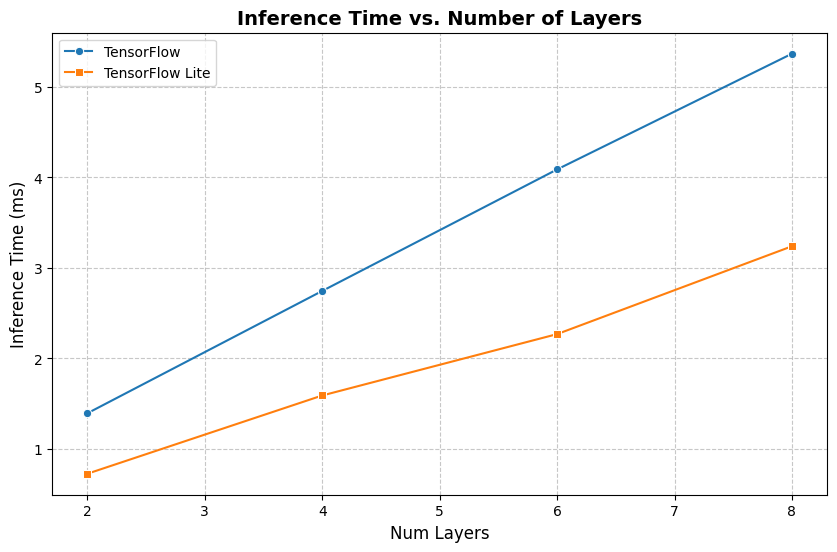

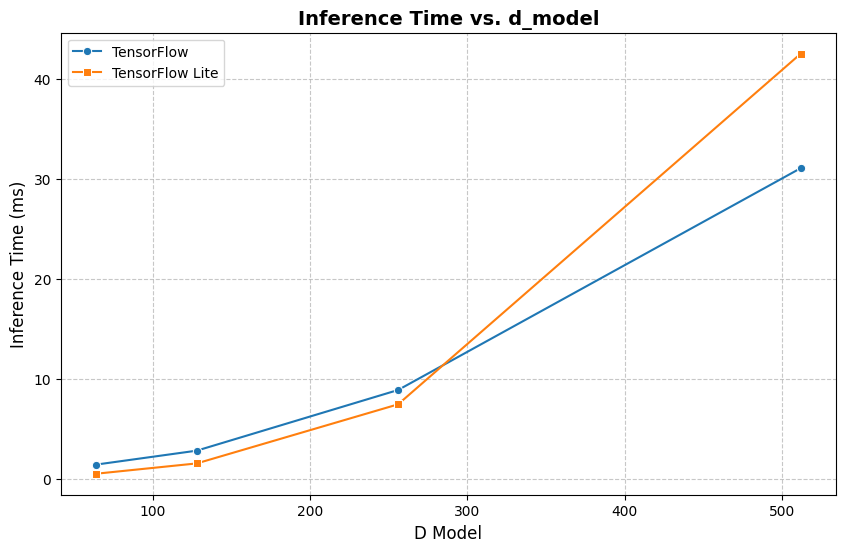

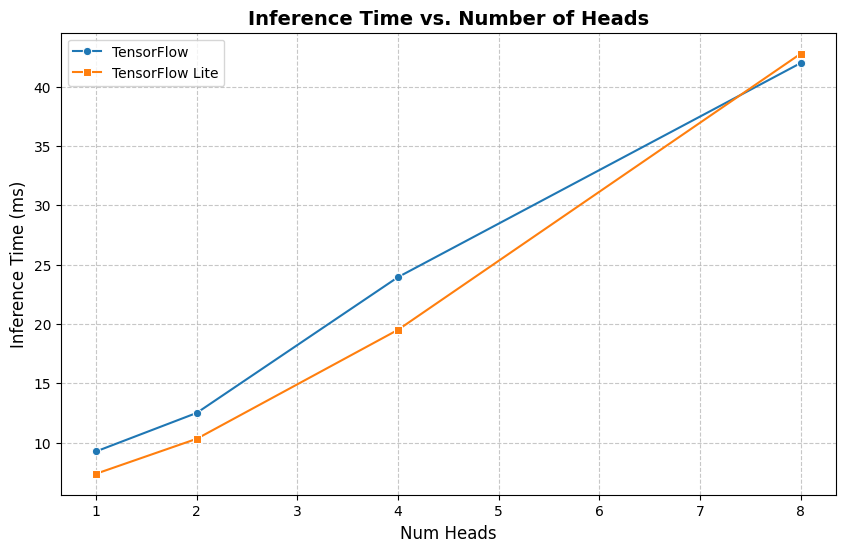

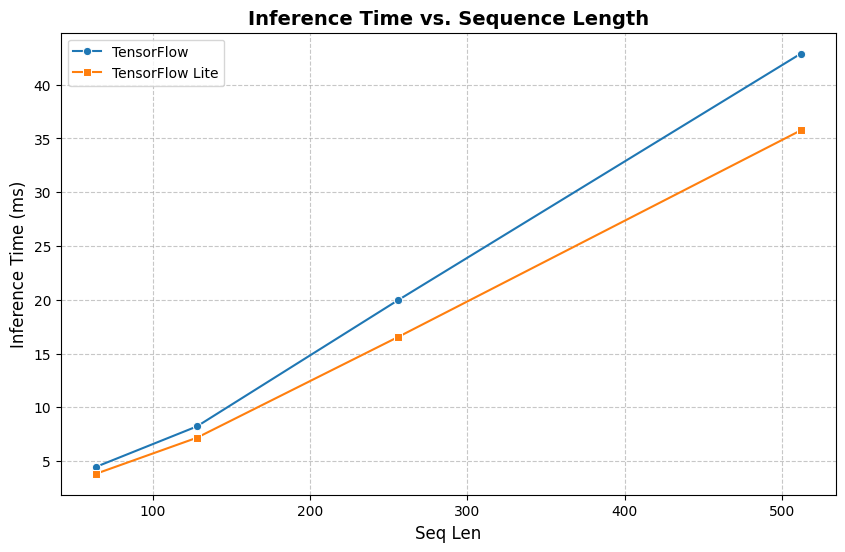

In [13]:
def plot_parameter(df, x, title, filename):
    plt.figure(figsize=(10, 6))
    # print(title, df[x])
    sns.lineplot(data=df, x=x, y='tf_time', marker='o', label='TensorFlow')
    sns.lineplot(data=df, x=x, y='tflite_time', marker='s', label='TensorFlow Lite')
    plt.xlabel(x.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Inference Time (ms)', fontsize=12)
    plt.title(f'Inference Time vs. {title}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.tight_layout()
    # plt.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot: Inference Time vs. Number of Layers
df_layers = df.iloc[:4]
plot_parameter(df_layers, 'num_layers', 'Number of Layers', 'inference_time_vs_layers')

# Plot: Inference Time vs. d_model
df_d_model = df.iloc[4:8]
plot_parameter(df_d_model, 'd_model', 'd_model', 'inference_time_vs_d_model')

# Plot: Inference Time vs. Number of Heads
df_heads = df.iloc[8:12]
plot_parameter(df_heads, 'num_heads', 'Number of Heads', 'inference_time_vs_heads')

# Plot: Inference Time vs. Sequence Length
df_seq_len = df.iloc[12:16]
plot_parameter(df_seq_len, 'seq_len', 'Sequence Length', 'inference_time_vs_seq_len')

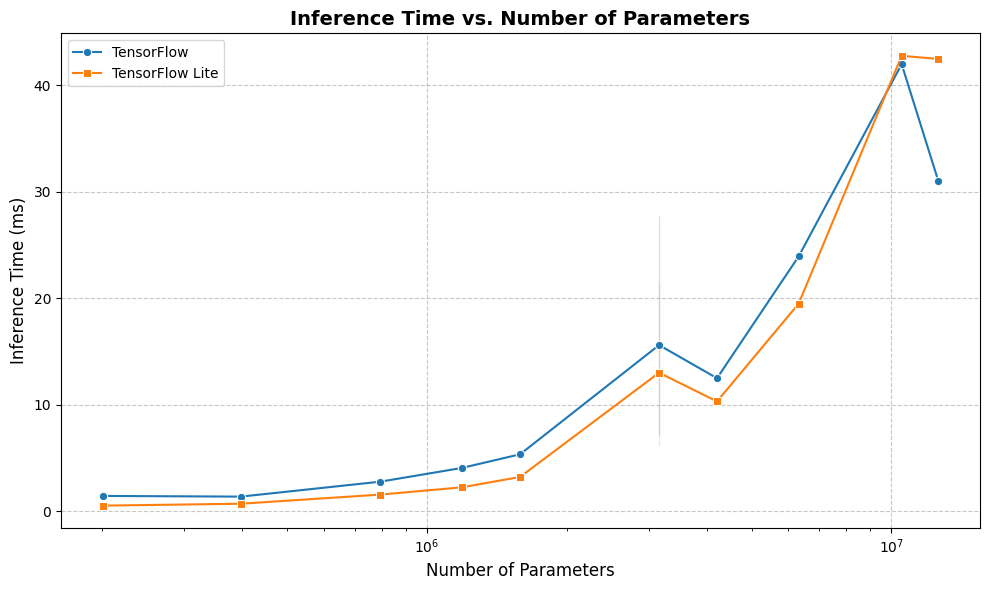

In [14]:
# Plot: Inference Time vs. Number of Parameters
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='num_params', y='tf_time', marker='o', label='TensorFlow')
sns.lineplot(data=df, x='num_params', y='tflite_time', marker='s', label='TensorFlow Lite')
plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Inference Time (ms)', fontsize=12)
plt.title('Inference Time vs. Number of Parameters', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.tight_layout()
plt.savefig('inference_time_vs_params.png', dpi=300, bbox_inches='tight')
plt.show()

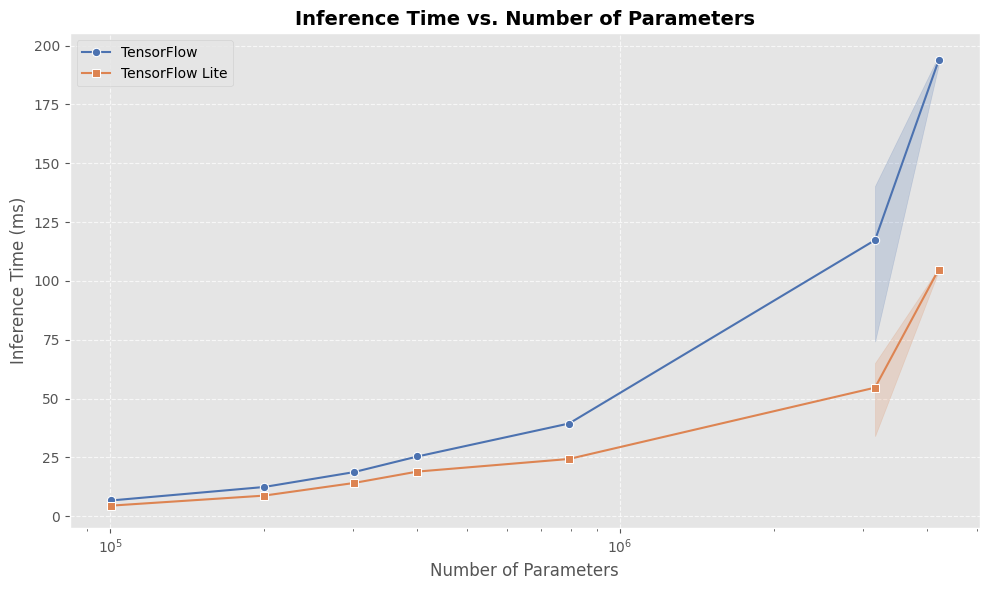

In [77]:
# Plot: Inference Time vs. Number of Parameters
plt.figure(figsize=(10, 6))
df_layers = df[df['tf_time'] < 250]
sns.lineplot(data=df_layers, x='num_params', y='tf_time', marker='o', label='TensorFlow')
sns.lineplot(data=df_layers, x='num_params', y='tflite_time', marker='s', label='TensorFlow Lite')
plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Inference Time (ms)', fontsize=12)
plt.title('Inference Time vs. Number of Parameters', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.tight_layout()
plt.savefig('inference_time_vs_params.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# Create a summary plot
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

plot_parameter(df_layers, 'num_layers', 'tf', 'Number of Layers', axes[0])
plot_parameter(df_d_model, 'd_model', 'tf', 'd_model', axes[1])
plot_parameter(df_heads, 'num_heads', 'tf', 'Number of Heads', axes[2])
plot_parameter(df_seq_len, 'seq_len', 'tf', 'Sequence Length', axes[3])

sns.scatterplot(data=df, x='num_params', y='tf_time', label='TensorFlow', ax=axes[4])
sns.scatterplot(data=df, x='num_params', y='tflite_time', label='TensorFlow Lite', ax=axes[4])
axes[4].set_xlabel('Number of Parameters', fontsize=12)
axes[4].set_ylabel('Inference Time (ms)', fontsize=12)
axes[4].set_title('Inference Time vs. Number of Parameters', fontsize=14, fontweight='bold')
axes[4].legend(fontsize=10)
axes[4].grid(True, linestyle='--', alpha=0.7)
axes[4].set_xscale('log')

# Remove the last unused subplot
fig.delaxes(axes[5])

plt.tight_layout()
fig.suptitle('Transformer Model Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.savefig('transformer_performance_summary.png', dpi=300, bbox_inches='tight')
# plt.close()
plt.show()
# plt.close()

In [ ]:
# Create a table with all the results
result_table = df.sort_values('num_params')
result_table['params_diff'] = result_table['num_params'].diff()
result_table['tf_time_diff'] = result_table['tf_time'].diff()
result_table['tflite_time_diff'] = result_table['tflite_time'].diff()
plt.figure(figsize=(20, len(result_table) * 0.5))
plt.axis('off')
table = plt.table(cellText=result_table.values,
                  colLabels=result_table.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)
plt.title('Transformer Model Performance Results', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('transformer_performance_table.png', dpi=300, bbox_inches='tight')
plt.show()

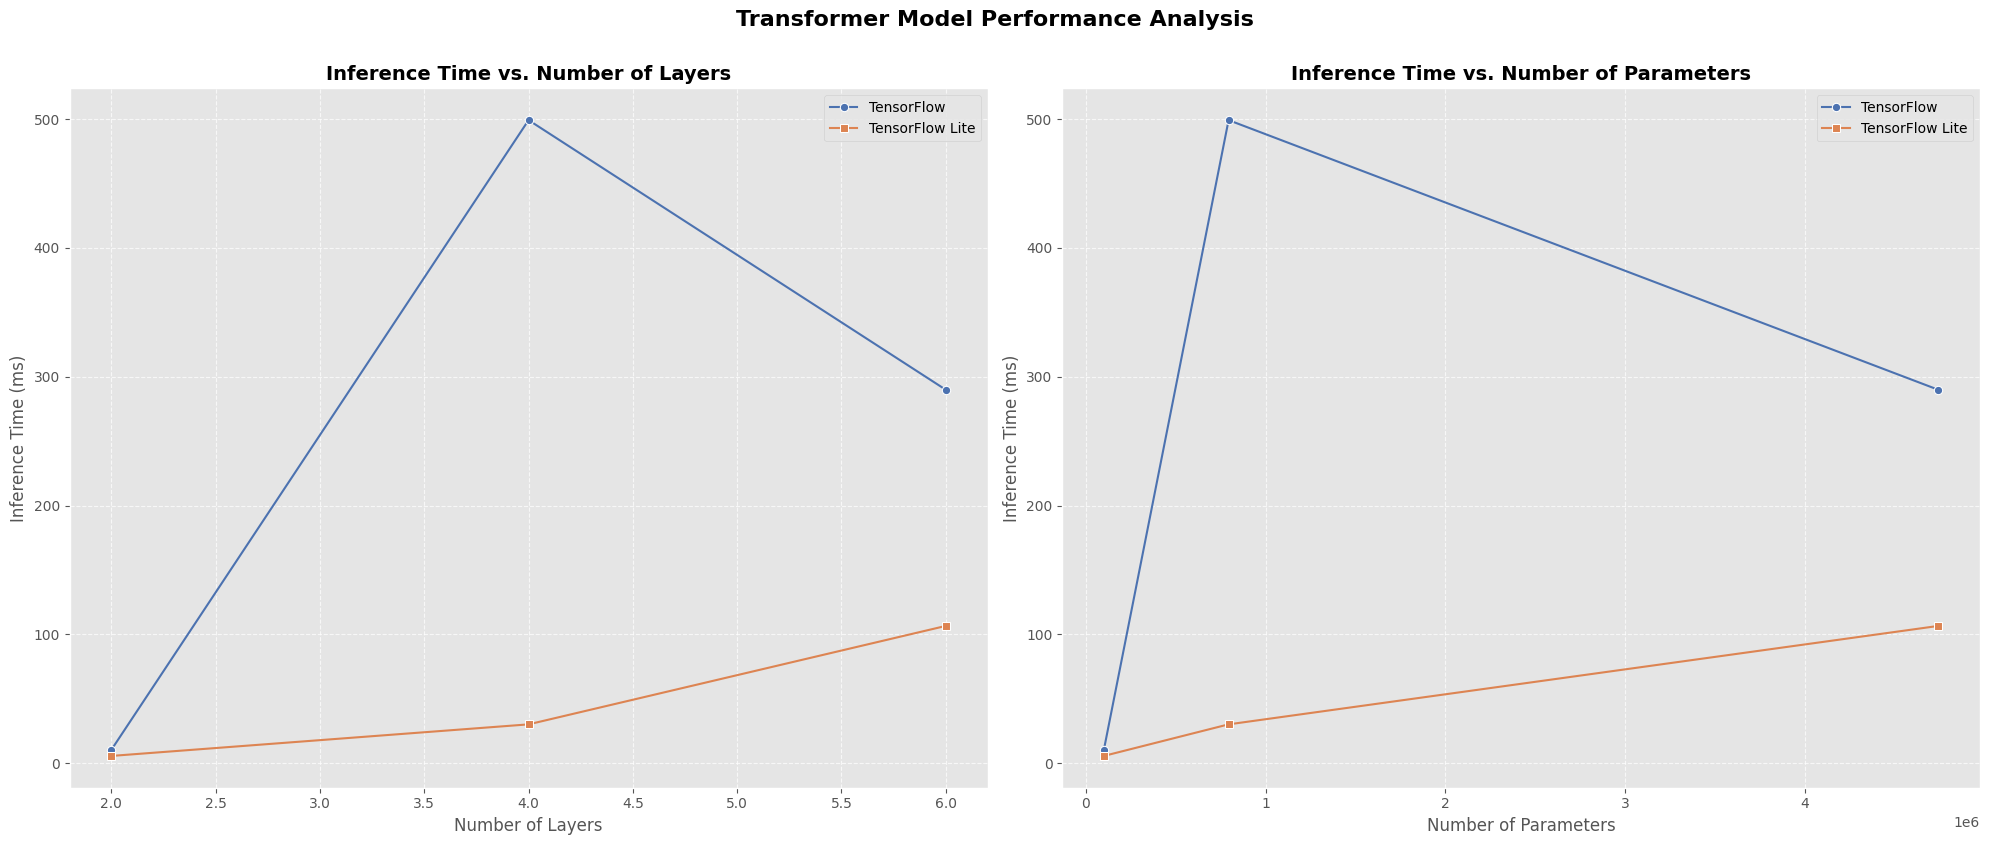

<Figure size 640x480 with 0 Axes>

In [26]:
plt.style.use('ggplot')
sns.set_palette("deep")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot: Inference Time vs. Number of Layers
sns.lineplot(data=df, x='num_layers', y='tf_time', marker='o', label='TensorFlow', ax=ax1)
sns.lineplot(data=df, x='num_layers', y='tflite_time', marker='s', label='TensorFlow Lite', ax=ax1)
ax1.set_xlabel('Number of Layers', fontsize=12)
ax1.set_ylabel('Inference Time (ms)', fontsize=12)
ax1.set_title('Inference Time vs. Number of Layers', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot: Inference Time vs. Number of Parameters
sns.lineplot(data=df, x='num_params', y='tf_time', marker='o', label='TensorFlow', ax=ax2)
sns.lineplot(data=df, x='num_params', y='tflite_time', marker='s', label='TensorFlow Lite', ax=ax2)
ax2.set_xlabel('Number of Parameters', fontsize=12)
ax2.set_ylabel('Inference Time (ms)', fontsize=12)
ax2.set_title('Inference Time vs. Number of Parameters', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)

# Use scientific notation for x-axis in the second plot
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Adjust layout and add a overall title
plt.tight_layout()
fig.suptitle('Transformer Model Performance Analysis', fontsize=16, fontweight='bold', y=1.05)

# Show the plot
plt.show()

# Save the plot
plt.savefig('transformer_performance_analysis.png', dpi=300, bbox_inches='tight')

In [21]:
# !pip install pandas